In [2]:
from datasets import load_dataset

# Load just a small subset of the Stack v2 dataset with 16k tokens
dataset = load_dataset("NoahEJ/stack-v2-16384-tokens", split="train", streaming=True)


subset = dataset.take(100)
subset_list = list(subset)
# Print basic info about the subset
print("Dataset structure:", subset_list)


/home/stalaei/miniconda3/envs/llm_effective_depth/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset structure: [{'blob_id': 'd786e89b9d478dcff3c541c89731247075d078c3', 'language': 'Python', 'input_ids': [14550, 30004, 13, 29992, 8921, 29901, 259, 10015, 9548, 1089, 30004, 13, 29992, 12346, 29901, 29871, 413, 264, 29992, 29894, 759, 645, 29883, 29889, 510, 30004, 13, 29992, 3259, 29901, 259, 29896, 29889, 29896, 29941, 30004, 13, 30004, 13, 6359, 297, 263, 934, 310, 19006, 2983, 322, 1653, 13747, 19006, 2342, 1980, 6756, 13, 3166, 1438, 2983, 22993, 13, 30004, 13, 12008, 30004, 13, 30004, 13, 30004, 13, 5215, 10908, 4422, 30004, 13, 5215, 10908, 7638, 30004, 13, 30004, 13, 5215, 337, 30004, 13, 5215, 10876, 30004, 13, 5215, 528, 4422, 30004, 13, 30004, 13, 29937, 1122, 3440, 714, 297, 278, 5434, 30004, 13, 5215, 282, 2158, 30004, 13, 407, 353, 282, 2158, 29889, 6572, 4349, 4040, 1639, 29898, 12860, 29922, 29946, 8443, 13, 407, 21979, 353, 7700, 30004, 13, 30004, 13, 29937, 2280, 3651, 30004, 13, 3385, 8977, 2917, 353, 3336, 13, 1678, 525, 2052, 6594, 29915, 584, 3336, 13, 4706

In [3]:
from transformers import AutoTokenizer

# Load the Llama 3 tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

# Function to decode a single example
def decode_tokens(input_ids):
    return tokenizer.decode(input_ids)

# Decode the first example to see what it looks like
first_example = subset_list[1]
decoded_text = decode_tokens(first_example['input_ids'])
print("Decoded text from first example:")
print(decoded_text)

# Decode all examples
decoded_texts = [decode_tokens(ex['input_ids']) for ex in subset_list]

# Print how many examples we decoded
print(f"\nDecoded {len(decoded_texts)} examples in total")


Decoded text from first example:
land' : r'\bBenchlands\b',
    'Pritchard' : r'\bPitchard\b',
}

# regex search - set the ships as
reShipsAs = re.compile(r'\(ships?\s', re.IGNORECASE)

# the order in which we pull multiple single match attributes 
defaultorderlist=[['Tok'], ['Oak'], ['Res'], ['RR'], ['Landslide'], ['Yount'], ['RRR'], ['Son'], ['Ruth'], ['Napa'], ['Helena'], ['SRH'], ['SLH'], ['SMV'], ['SLD'], ['Paso'], ['Alex'], ['Single'], ['Estate']]
    
### FUNCTIONS ############################################

#########################################################################################
def globalVariableCheck( debug=False ):
    # check for liquor definitions that are in noGrapeLookup
    # these will never execute
    for liquor in liquorLookup:
        if liquor in noGrapeLookup:
            print('WARNING:liquorLookup regexs will never execute - they are in noGrapeLookup:', liquor)
        if liquor in ignoreGrapeLookup:
            print('WARNING:liquorLookup re

In [4]:
# Group examples by blob_id and sort by index_in_file within each group
from collections import defaultdict
grouped_by_blob = defaultdict(list)
for example, decoded_text in zip(subset_list, decoded_texts):
    grouped_by_blob[example['blob_id']].append({
        'text': decoded_text,
        'index_in_file': example['index_in_file'],
        'language': example['language']
    })

# Sort each group by index_in_file and merge texts
decoded_dataset = []
for blob_id, examples in grouped_by_blob.items():
    sorted_examples = sorted(examples, key=lambda x: x['index_in_file'])
    merged_text = ''.join(ex['text'] for ex in sorted_examples)
    decoded_dataset.append({
        'blob_id': blob_id,
        'language': sorted_examples[0]['language'],  # Take language from first example
        'text': merged_text,
    })
    
# Truncate each text to first 16k tokens
MAX_TOKENS = 2000

truncated_dataset = []
for example in decoded_dataset:
    # Tokenize and truncate to MAX_TOKENS
    tokens = tokenizer.encode(example['text'])[:MAX_TOKENS]
    
    # Decode back to text
    truncated_text = tokenizer.decode(tokens)
    
    truncated_dataset.append({
        'blob_id': example['blob_id'],
        'language': example['language'],
        'text': truncated_text
    })

# Replace decoded_dataset with truncated version
decoded_dataset = truncated_dataset
    
print(f"Decoded {len(decoded_dataset)} examples in total")

Decoded 39 examples in total


In [5]:
# Push to HF Hub
from datasets import Dataset
from huggingface_hub import HfApi

# Convert to Dataset object
hf_dataset = Dataset.from_list(decoded_dataset)

# Login to Hugging Face (you'll need to have run `huggingface-cli login` first)
api = HfApi()

# Push to Hub - replace USERNAME with your HF username
# You may want to change the dataset name and provide a meaningful description
hf_dataset.push_to_hub(
    "stalaei/stack-v2-subset-all-above-15k-tokens",  
    private=False
)

print("Dataset successfully pushed to Hugging Face Hub")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Dataset successfully pushed to Hugging Face Hub


Token length statistics:
Mean: 1510.5
Median: 1515.0
Min: 1258
Max: 1790
Standard deviation: 116.4


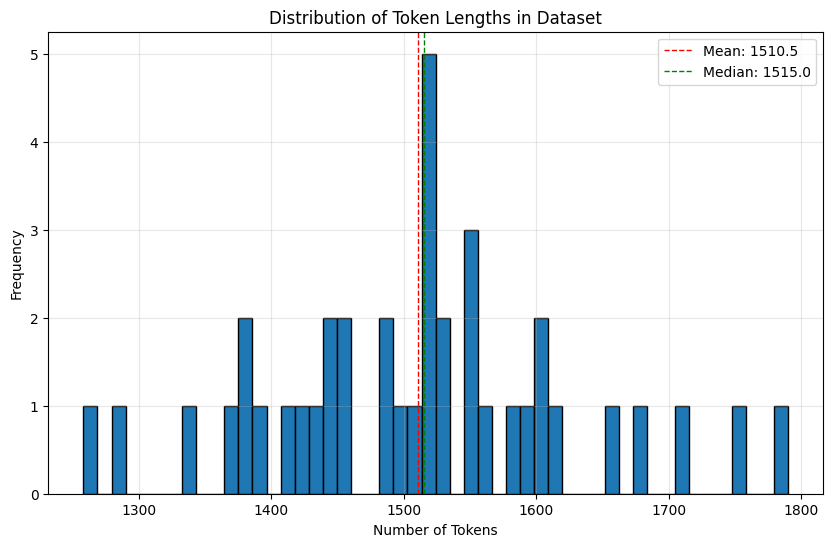

In [6]:
import sys
sys.path.append("/home/stalaei/projects/llm_effective_depth/analysis")

# Import necessary libraries
import matplotlib.pyplot as plt
from lib.models import create_model
import numpy as np

# Create model to get tokenizer
llm = create_model("llama_3.1_8b")
tokenizer = llm.tokenizer

# Tokenize all texts
token_lengths = [len(tokenizer.encode(text['text'])) for text in decoded_dataset]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Token Lengths in Dataset')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

# Add some statistics
plt.axvline(np.mean(token_lengths), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(token_lengths):.1f}')
plt.axvline(np.median(token_lengths), color='green', linestyle='dashed', linewidth=1, label=f'Median: {np.median(token_lengths):.1f}')

plt.legend()
plt.grid(True, alpha=0.3)

# Print some statistics
print(f"Token length statistics:")
print(f"Mean: {np.mean(token_lengths):.1f}")
print(f"Median: {np.median(token_lengths):.1f}")
print(f"Min: {min(token_lengths)}")
print(f"Max: {max(token_lengths)}")
print(f"Standard deviation: {np.std(token_lengths):.1f}")

plt.show()
